In [5]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import FeatureAgglomeration
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import pandas as pd
import scipy as sp
import numpy as np

from models import AggregateLearner

In [6]:
def performanceP(true, f1, acc, n=1000, rs=42):
    np.random.seed(rs)

    f1_dist = np.array([f1_score(true, np.random.choice(2, len(true)))
                        for _ in range(n)])
    f1N = np.sum(f1_dist > f1)
    f1p = 1.0 * f1N / n
    print("F1: {0} (p = {2}; chance = {3})".format(f1, f1p, np.mean(f1_dist)))
    
    acc_dist = np.array([accuracy_score(true, np.random.choice(2, len(true)))
                for _ in range(n)])
    accN = np.sum(acc_dist > acc)
    accp = 1.0 * accN / n
    print("Acc: {0} (p = {2}; chance = {3})".format(acc, accp, np.mean(acc_dist)))
    return f1p, accp

In [32]:
# Load Dataset
df = pd.read_hdf('../data/aggregation_dset100x1x1x20.h5')
df = df[df["instrumentation"] == "sparse"]

In [11]:
# Create list of targets
targets = ["age", "sex"]

# Create pre-processing components
datavars = ["graph", "rankgraph", "loggraph", "zgraph"]

# Create decomposition components
pca = ('pca', PCA(n_components=20))
fa = ('fa', FeatureAgglomeration(n_clusters=20))
embeds = [pca, fa]

# Create classifier components
svc = ('svc', SVC(class_weight="balanced", probability=True, max_iter=1e5))
lrc = ('lrc', LogisticRegression(class_weight="balanced", solver='liblinear', max_iter=1e5, penalty='l2'))
# gnb = ('gnb', GaussianNB())
# gpc = ('gpc', GaussianProcessClassifier())
# knn = ('knn', KNeighborsClassifier(n_neighbors=10))
# rfc = ('rfc', RandomForestClassifier(class_weight="balanced"))
# ada = ('ada', AdaBoostClassifier())
# clfs = [svc, lrc, gnb, gpc, knn, rfc, ada]
clfs = [svc, lrc]

In [14]:
observation = "simulation"
refstr = "ref"
jack = 100
rs = 41

results = []
targets = ['sex']
for t in targets:
    for dva in datavars:
        for e in embeds:
            for c in clfs:
                pipe = Pipeline([e, c])
                clf = AggregateLearner(df, pipe, data_id=dva, target_id=t, observation_id=observation,
                                       sample_id='subject', refstr=refstr, cvfolds=5, oos=0.2,
                                       jack=jack, triu=True, random_seed=rs, verbose=False)

                
                print(t, dva, e[0], c[0])
                perf = clf.fit(aggregation="ref")
                perf['f1'], perf['acc'], perf['p_f1'], perf['p_acc']
                results += [{
                    "target": t,
                    "preproc": dva,
                    "embedding": e[0],
                    "classifier": c[0],
                    "f1": perf['f1'],
                    "acc": perf['acc'],
                    "p_f1": perf['p_f1'],
                    "p_acc": perf['p_acc']
                }]

resdf = pd.DataFrame.from_dict(results)

sex graph pca svc
sex graph pca lrc
sex graph fa svc
sex graph fa lrc
sex rankgraph pca svc
sex rankgraph pca lrc
sex rankgraph fa svc
sex rankgraph fa lrc
sex loggraph pca svc
sex loggraph pca lrc
sex loggraph fa svc
sex loggraph fa lrc
sex zgraph pca svc
sex zgraph pca lrc
sex zgraph fa svc
sex zgraph fa lrc


In [15]:
resdf

,target,preproc,embedding,classifier,f1,acc,p_f1,p_acc
0,sex,graph,pca,svc,0.666667,0.50,0.125,0.391
1,sex,graph,pca,lrc,0.608696,0.55,0.248,0.241
2,sex,graph,fa,svc,0.709677,0.55,0.084,0.241
3,sex,graph,fa,lrc,0.636364,0.60,0.201,0.121
4,sex,rankgraph,pca,svc,0.750000,0.60,0.038,0.121
5,sex,rankgraph,pca,lrc,0.846154,0.80,0.001,0.002
6,sex,rankgraph,fa,svc,0.750000,0.60,0.038,0.121
7,sex,rankgraph,fa,lrc,0.600000,0.60,0.304,0.121
8,sex,loggraph,pca,svc,0.758621,0.65,0.026,0.049
9,sex,loggraph,pca,lrc,0.720000,0.65,0.057,0.049


In [16]:
perf

{'true': array([0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0.,
        1., 1., 1.]),
 'pred': array([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
        1., 0., 0.]),
 'acc': 0.7,
 'f1': 0.6666666666666666,
 'comp_acc': 0.5999999999999999,
 'comp_f1': 0.5774212715389186,
 'p_f1': 0.125,
 'p_acc': 0.021}

In [13]:
resdf

,target,preproc,embedding,classifier,f1,acc,p_f1,p_acc
0,age,graph,pca,svc,0.848485,0.75,0.000,0.010
1,age,graph,pca,lrc,0.814815,0.75,0.007,0.010
2,age,graph,fa,svc,0.866667,0.80,0.000,0.003
3,age,graph,fa,lrc,0.758621,0.65,0.047,0.053
4,age,rankgraph,pca,svc,0.823529,0.70,0.007,0.023
5,age,rankgraph,pca,lrc,0.838710,0.75,0.003,0.010
6,age,rankgraph,fa,svc,0.823529,0.70,0.007,0.023
7,age,rankgraph,fa,lrc,0.774194,0.65,0.030,0.053
8,age,loggraph,pca,svc,0.848485,0.75,0.000,0.010
9,age,loggraph,pca,lrc,0.827586,0.75,0.004,0.010


In [103]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

In [105]:
clf = PLSRegression(n_components=20, scale=True, tol=1e-6)
cv = KFold(n_splits=10)

In [121]:
ytrue, ypreds, r2 = [], [], []
for tr_, te_ in cv.split(X, y):
    Xtr, ytr = X[tr_], y[tr_]
    Xte, yte = X[te_], y[te_]
    
    clf.fit(Xtr, ytr)
    r2 += [clf.score(Xte, yte)]
    print(r2[-1])

    yn2 = clf.predict(Xte)
    ytrue += list(yte)
    ypreds += list(yn2)
    
    print(mean_absolute_error(yte, yn2))
print(np.mean(r2))

0.4093991983588986
11.53729439329409
0.188814027150623
13.307903997176812
0.042524294530983386
20.443162926225504
0.13158635498704896
19.611636542599616
0.4959089652318758
16.707535029178352
-1.9872000116811623
13.257070515847426
0.7111041996816074
9.099633041103518
-0.052171226116506375
15.16953409229849
0.37875446617619923
16.711844197151486
0.15749339577820098
17.65597486908079
0.047621366409776864


In [107]:
import matplotlib.pyplot as plt

%matplotlib inline

In [122]:
from sklearn.metrics import r2_score

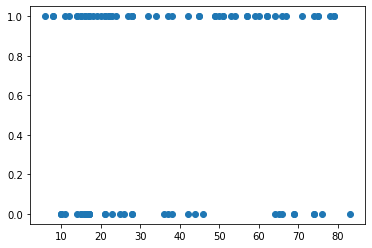

In [128]:
plt.scatter(ytrue, y)
# plt.plot(np.arange(100), np.arange(100))


In [66]:
clf.fit(X, y)
yn = clf.predict(X)

In [69]:
clf.score(X, y)

0.999989522996487

In [379]:
X = df.query('instrumentation=="sparse" and simulation=="ref"').rankgraph
_ind = np.triu_indices(n=83, k=1)
X = np.stack([g[_ind] for g in X])

y = np.stack(df.query('instrumentation=="sparse" and simulation=="ref"').sex)
dummy = np.zeros((len(y), 2))
dummy[:,0] = y == 0
dummy[:,1] = y == 1

In [380]:
X.shape, dummy.shape

((97, 3403), (97, 2))

In [381]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error, f1_score

In [382]:
clf = PLSRegression(n_components=20, scale=True, tol=1e-6)
clf = Pipeline([pca, lrc])
cv = StratifiedKFold(n_splits=10)

In [383]:
ytrue, ypreds, yn2 = [], [], []
for tr_, te_ in cv.split(X, y):
    Xtr, ytr = X[tr_], y[tr_]
    Xte, yte = X[te_], y[te_]
#     Xtr, ytr = X[tr_], dummy[tr_]
#     Xte, yte = X[te_], dummy[te_]
    
    clf.fit(Xtr, ytr)

    yn2 = clf.predict(Xte)
    ytrue += list(yte)
    ypreds += list(yn2)
    
    y_t = yte
    y_p = np.array(yn2 > 0.5, dtype=int)
#     y_t = np.argmax(yte, axis=1)
#     y_p = np.argmax(yn2, axis=1)

    print(f1_score(y_t, y_p))

0.4615384615384615
0.7272727272727272
0.7142857142857143
0.8333333333333334
0.7692307692307692
0.5714285714285715
0.4
0.9090909090909091
0.6
0.4444444444444445


In [384]:
y_t = ytrue
y_p = np.array(np.array(ypreds) > 0.5, dtype=int)

# y_t = np.argmax(ytrue, axis=1)
# y_p = np.argmax(ypreds, axis=1)

f1_score(y_t, y_p)

0.6495726495726496

array([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1])

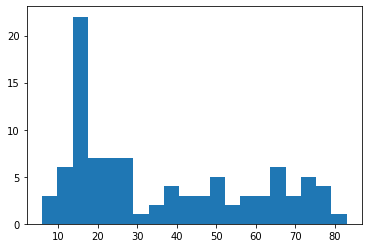

In [527]:
y = np.stack(df.query('instrumentation=="sparse" and simulation=="ref"').age)
cnt, bins, fig = plt.hist(y, bins=20)

In [529]:
for c in cnt:
    if c 

array([ 6.  ,  9.85, 13.7 , 17.55, 21.4 , 25.25, 29.1 , 32.95, 36.8 ,
       40.65, 44.5 , 48.35, 52.2 , 56.05, 59.9 , 63.75, 67.6 , 71.45,
       75.3 , 79.15, 83.  ])

((80,), (80, 3403))

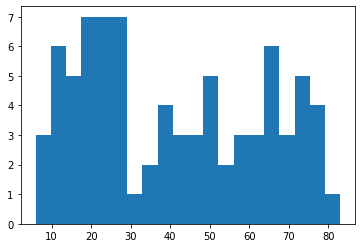

In [520]:
np.random.seed(42)
df_bulk_ages = df.copy()

bl, bu = 13.5, 17.5
n = 5
qstr = 'instrumentation=="sparse" and simulation=="ref" and age < {0} and age > {1}'
# for 
df_bulk_ages = df_bulk_ages.query(qstr.format(bu, bl))
subs = df_bulk_ages.sample(n=n).subject

remove_subs = set(df_bulk_ages.subject) - set(subs)
df2 = df.copy()
df2 = df2[~df.subject.isin(remove_subs)]
y = np.stack(df2.query('instrumentation=="sparse" and simulation=="ref"').age)
len(y)
plt.hist(y, bins=20)

X = df2.query('instrumentation=="sparse" and simulation=="ref"').loggraph
_ind = np.triu_indices(n=83, k=1)
X = np.stack([g[_ind] for g in X])
y.shape, X.shape

In [521]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error, f1_score, r2_score

In [522]:
clf = PLSRegression(n_components=20, scale=True, tol=1e-6)
cv = KFold(n_splits=10)

# clf = Pipeline([pca, lrc])
# cv = StratifiedKFold(n_splits=10)

In [523]:
ytrue, ypred, yn2 = [], [], []
for tr_, te_ in cv.split(X, y):
    Xtr, ytr = X[tr_], y[tr_]
    Xte, yte = X[te_], y[te_]
    
    clf.fit(Xtr, ytr)
    print(clf.score(Xte, yte))
    yn2 = clf.predict(Xte)
    ytrue += list(yte)
    ypred += list(yn2)

0.512564180799354
0.39385978353986717
0.594923403866862
0.3318626971319736
0.39889809025327916
-3.650126646689751
0.7122143686516871
0.5296271582548718
0.21593650277094678
0.1863242004164538


In [524]:
mean_absolute_error(ytrue, ypred), np.sqrt(r2_score(ytrue, ypred))

(13.934575256546776, 0.6598779018985298)

loggraph - scaled=True -> r=0.65

In [479]:
mean_absolute_error(ytrue, ypred), np.sqrt(r2_score(ytrue, ypred))

(15.016673598963953, 0.6278729819131954)

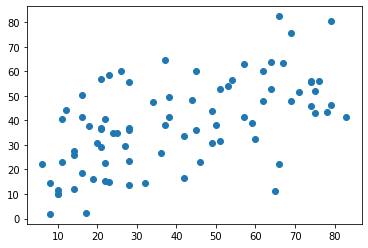

In [461]:
plt.scatter(ytrue, ypred)